In [5]:
import numpy as np
import torch

from torch import nn
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import utils
import models
import trainer
import mclnn

In [ ]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
#     hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data = False

In [ ]:
conf.columns, conf.column_encoder = utils.read_columns()

In [ ]:
train_x, train_y, _ = utils.read_dataset_split("./data/train_curated.csv", "./splits/split/train", conf, lambda s: s)
test_x, test_y, _ = utils.read_dataset_split("./data/train_curated.csv", "./splits/split/val", conf, lambda s: s)

100%|██████████| 506/506 [00:05<00:00, 87.76it/s] 


In [ ]:
all_rooms_meta, all_rooms = utils.read_filters("./filters/", conf, lambda s: s)

100%|██████████| 73/73 [00:05<00:00, 10.92it/s]


In [ ]:
test_x = list(map(lambda s: utils.trim_and_mel(conf, s), test_x))

In [ ]:
train_dataset = trainer.SoundAugDataset(train_x, train_y, 
                                        transform = lambda s: utils.audio_to_melspectrogram(conf, s),
                                        room_filters=all_rooms[:3], 
                                        params={
                                                    "max_size":len(train_x),
                                                    "max_n_mixed":2,
#                                                     "change_pitch":0.1,
#                                                     "change_pitch_max":1,
                                                    "add_echo":0.5,
#                                                     "harmonic_percussive":0.1,
#                                                     "noise_magnitude":0.00005
                                               },
                                        config=conf,
                                        seed=42)
test_dataset = trainer.SoundDataset(test_x, test_y)

In [ ]:
aug_coll = trainer.AugmentationCollator(conf, None)
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=aug_coll, shuffle=True, num_workers=0)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)

In [ ]:
model = nn.Sequential(
    mclnn.CLNNModule(128, 256, 4, dilation=1),
    nn.LeakyReLU(),
    mclnn.BatchNorm(256),
    mclnn.CLNNModule(256, 256, 4, dilation=1),
    nn.LeakyReLU(),
    mclnn.TemporalPool(2),
    mclnn.BatchNorm(256),
    mclnn.CLNNModule(256, 256, 4, dilation=1),
    nn.LeakyReLU(),
    mclnn.TemporalPool(2),
    mclnn.CLNNModule(256, 256, 4),
    nn.LeakyReLU(),
    mclnn.TemporalPool(4),
    mclnn.BatchNorm(256),
    mclnn.Flatten(),
    nn.Linear(256*8, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, len(conf.columns))
)

In [ ]:
device = torch.device("cuda")

model = model.to(device)

In [ ]:
def optimizer_factory(params):
    result = torch.optim.Adam(params, lr=1e-3)
    return result
    
def scheduler_factory(optimizer):
    result = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
    return result

In [ ]:
tr = trainer.Trainer(model, optimizer_factory, scheduler_factory, device, {"path":"./experiments/paper_final/"})

Saving the weights and metrics to  ./experiments/paper_final/2019-06-17.19.17.13


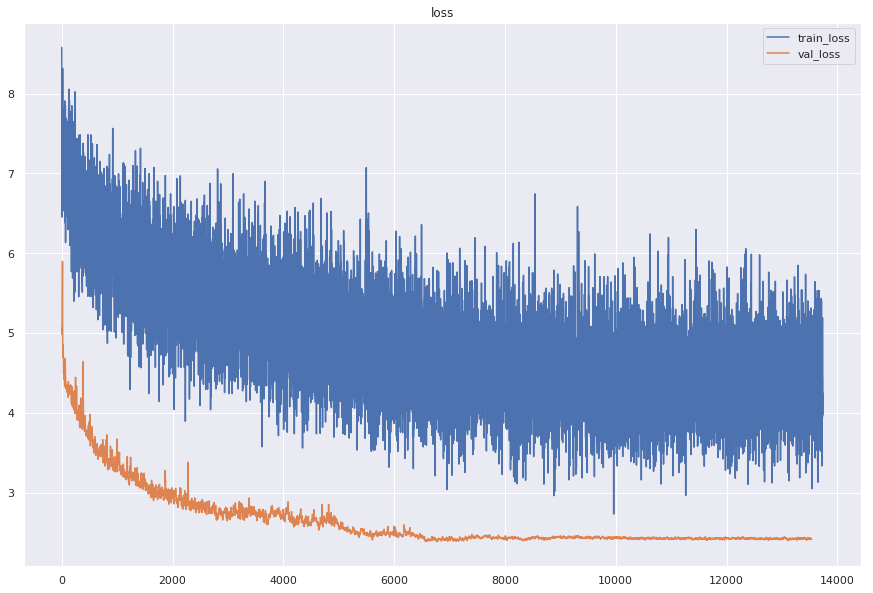

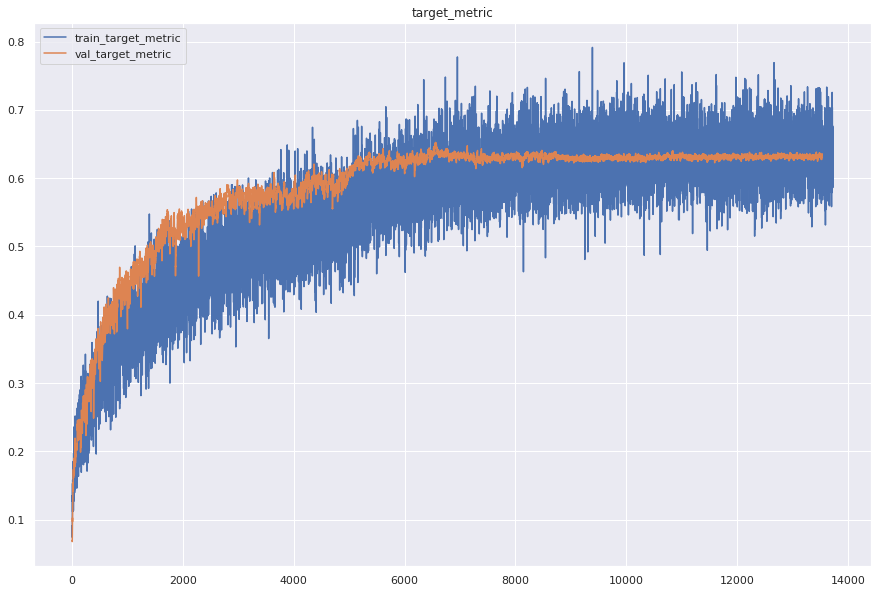

In [34]:
tr.train(
    loaders={"train_loader":train_loader, "test_loader":test_loader},
    params={"epochs":1, "grad_clip_norm":10.0, "validate_every":25},
)

In [ ]:
tr.save_path

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


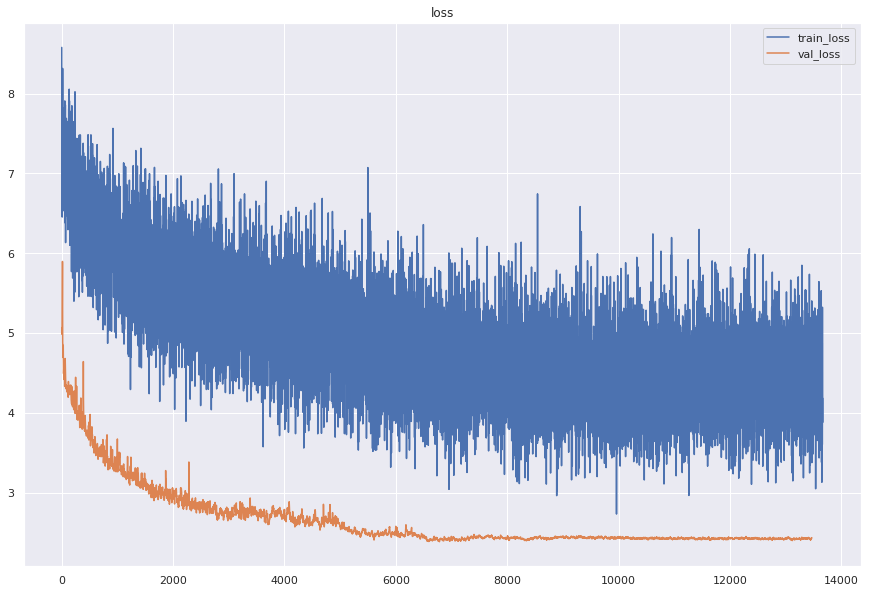

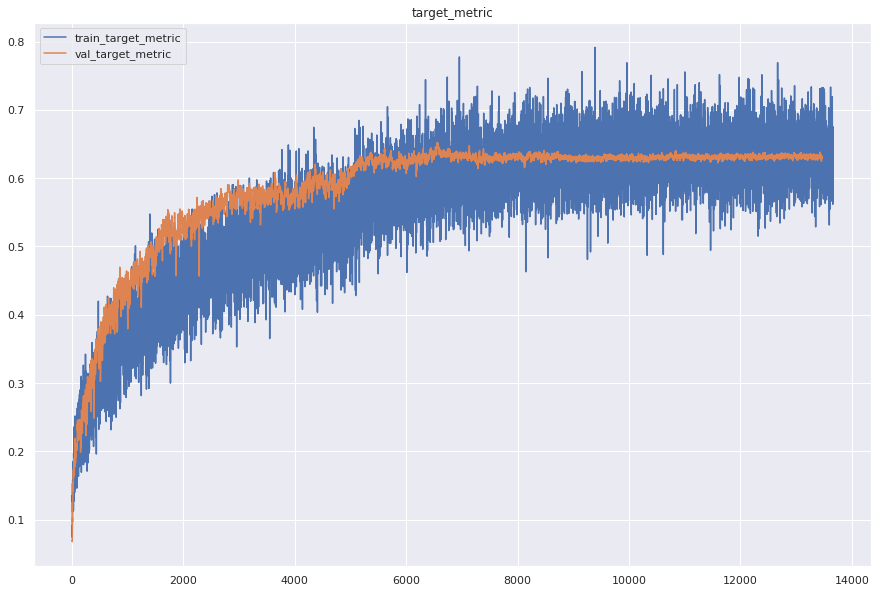

In [20]:
tr.plot(tr.train_metrics, tr.val_metrics)